Requested Citation Acknowledgment:
IEEE OTCBVS WS Series Bench; J. Davis and M. Keck, "A two-stage approach to person detection in thermal imagery," In Proc. Workshop on Applications of Computer Vision, January 2005

# Imports

In [1]:
### Object Detection with Faster R-CNN and RetinaNet in PyTorch ###

!pip -q install torch torchvision torchmetrics matplotlib
# !pip install pycocotools
# !pip install faster-coco-eval
#!pip install tqdm

import re, random, time
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.auto import tqdm

import os, json

import torch
from torch.utils.data import Dataset, DataLoader
import torch.cuda.amp as amp
from torch.serialization import validate_cuda_device

import torchvision
from torchvision.transforms import functional as TF
from torchvision.models.detection import RetinaNet_ResNet50_FPN_V2_Weights, FasterRCNN_ResNet50_FPN_V2_Weights, fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
import torchvision.transforms as T
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 19.2 MB/s eta 0:00:00
Using device: cuda


# Data Preprocessing and creating data Loaders

In [2]:
_BOX_RE = re.compile(r"\((\d+)\s+(\d+)\s+(\d+)\s+(\d+)\)")

def parse_utu_groundtruth(json_dir, image_filenames):
    """
    Parses Labelme JSON files and returns a dictionary of bounding box tensors.
    Format: [xmin, ymin, xmax, ymax]
    """
    out = {}
    for fname in image_filenames:
        json_path = os.path.join(json_dir, os.path.splitext(fname)[0] + '.json')

        if not os.path.exists(json_path):
            # No annotations for this image
            out[fname] = torch.zeros((0, 4), dtype=torch.float32)
            continue

        with open(json_path, 'r') as f:
            data = json.load(f)

        boxes = []
        for shape in data.get('shapes', []):
            if shape['label'] == 'person':
                # Labelme stores points as [[x1, y1], [x2, y2]]
                p1, p2 = shape['points']
                xmin = min(p1[0], p2[0])
                ymin = min(p1[1], p2[1])
                xmax = max(p1[0], p2[0])
                ymax = max(p1[1], p2[1])
                boxes.append([xmin, ymin, xmax, ymax])

        if boxes:
            out[fname] = torch.tensor(boxes, dtype=torch.float32)
        else:
            out[fname] = torch.zeros((0, 4), dtype=torch.float32)
    return out

In [3]:

class UTUPedestrianDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # Load all image files, sorting them to ensure alignment with json
        self.imgs = sorted([f for f in os.listdir(root) if f.endswith(('.jpg', '.png'))])
        # Use the parser we created earlier
        self.ground_truth = parse_utu_groundtruth(root, self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        boxes = self.ground_truth[self.imgs[idx]]
        num_objs = boxes.shape[0]

        # Labels: 1 for pedestrian (0 is usually background)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        # Area is needed for COCO evaluation
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
# 1. Define Transforms
def get_transform():
    return T.Compose([T.ToTensor()])

# 2. Define Collate Function (Crucial for Object Detection)
def collate_fn(batch):
    return tuple(zip(*batch))

# Mount Google Drive to access dataset files
from google.colab import drive
drive.mount('/content/drive')

# Paths
train_path = '/content/drive/My Drive/ComputerVisionandSensorFusion/pedestrian_dataset_UTU/train'
test_path = '/content/drive/My Drive/ComputerVisionandSensorFusion/pedestrian_dataset_UTU/test'

# Ensure the directories exist before proceeding
if not os.path.exists(train_path):
    raise FileNotFoundError(f"Train path does not exist: {train_path}. Please update it to your dataset location.")
if not os.path.exists(test_path):
    raise FileNotFoundError(f"Test path does not exist: {test_path}. Please update it to your dataset location.")

train_dataset = UTUPedestrianDataset(train_path, get_transform())
test_dataset = UTUPedestrianDataset(test_path, get_transform())

# 4. Create Loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=2, # 2 batch size to mitigate OutOfMemoryError
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=2, # 2 batch size to mitigate OutOfMemoryError
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

print(f"Dataset initialized with {len(train_dataset)} training images.")

Mounted at /content/drive
Dataset initialized with 292 training images.


# Visualize two samples of the Training Data

In [5]:
def display_image_with_boxes(img_tensor, boxes, title="Image with Bounding Boxes"):
    """
    Displays an image tensor with bounding boxes.

    Args:
        img_tensor (torch.Tensor): Image tensor in [C, H, W] format.
        boxes (torch.Tensor): Bounding boxes in [xmin, ymin, xmax, ymax] format.
        title (str): Title for the plot.
    """
    img = TF.to_pil_image(img_tensor)
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    # Draw bounding boxes
    for box in boxes:
        xmin, ymin, xmax, ymax = box.tolist()

        # Create a rectangle path
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             fill=False, color='red', linewidth=2)
        ax.add_patch(rect)

    ax.set_title(title)
    ax.axis('off')
    plt.show()

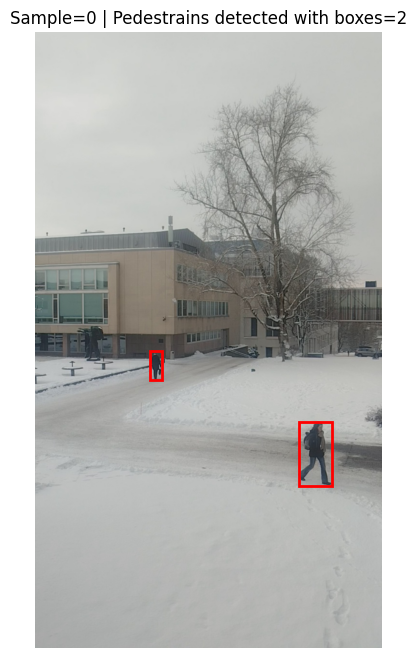

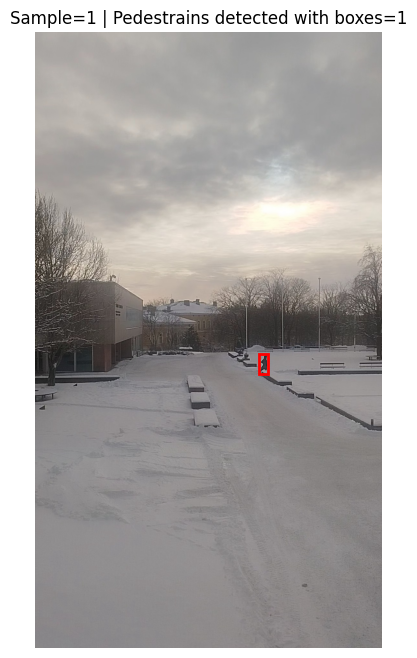

In [6]:
for i, (images, targets) in enumerate(train_loader):
    if i >= 2: # 2 samples images to be shown here
        break

    img_tensor = images[0]  # Get the first image from the batch
    boxes = targets[0]['boxes'] # Get the bounding boxes for the first image
    display_image_with_boxes(img_tensor, boxes, title=f"Sample={i} | Pedestrains detected with boxes={len(boxes)}")


# Create the following methods for training and evaluation:
### 1. Train_one_epoch
### 2. Evaluate_map (mean Average Precision)
### 3. Time_inference

In [7]:
# Train one-epoch function
def train_one_epoch(model, loader, optimizer, device, epoch=None):
    model.train()
    total_loss = 0
    scaler = torch.amp.GradScaler('cuda')

    for images, targets in loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Backward pass with gradient scaling
        scaler.scale(losses).backward()

        # Added gradient clipping before optimizer step to prevent NaN loss from gradient explosion (for RetinaNet's focal loss)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        total_loss += losses.item()

    avg_loss = total_loss / len(loader)
    return avg_loss

# Evaluate_map function
@torch.no_grad()
def evaluate_map(model, loader, device):
    """mAP evaluation using torchmetrics.
    Returns a dict with keys like 'map', 'map_50', 'mar_100', ...
    """
    model.eval()

    # Temporarily lower score_thresh to 0.05 during evaluation. During training we use score_thresh=0.3 to suppress noisy boxes, but at eval time this threshold is too high and suppresses valid detections — causing mAP to collapse to near zero. We restore the original threshold after evaluation.
    original_thresh = getattr(model, 'score_thresh', None)
    if original_thresh is not None:
        model.score_thresh = 0.05

    metric = MeanAveragePrecision()

    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Evaluating mAP"):
            images = list(img.to(device) for img in images)

            # Model output in eval mode is a list of dicts: [{'boxes':..., 'labels':..., 'scores':...}]
            # Use autocast for mixed precision in evaluation too for consistency and potential speedup
            with torch.amp.autocast('cuda'):
                outputs = model(images)

            preds = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
            target = [{k: v.to('cpu') for k, v in t.items()} for t in targets]

            metric.update(preds, target)

    # Restore original score_thresh after evaluation
    if original_thresh is not None:
      model.score_thresh = original_thresh

    return metric.compute()

# Time_inference function
@torch.no_grad()
def time_inference(model, loader, dataset, device, n_images=100, warmup=10):
    """Average inference time per image (ms)."""
    model.eval()
    times = []

    # Warm up the GPU (standard practice for accurate benchmarking)
    dummy_input = [torch.randn(3, 300, 300).to(device)]
    for _ in range(10):
        # MODIFIED: updated deprecated torch.cuda.amp.autocast to torch.amp.autocast('cuda')
        with torch.amp.autocast('cuda'):
            _ = model(dummy_input)

    with torch.no_grad():
        for images, _ in loader:
            images = list(img.to(device) for img in images)

            start_time = time.time()
            # Updated deprecated torch.cuda.amp.autocast to torch.amp.autocast('cuda')
            with torch.amp.autocast('cuda'):
                _ = model(images)
            if device.type == 'cuda':  # Use .type attribute — device is a torch.device object, not a string
                torch.cuda.synchronize()
            end_time = time.time()

            batch_time = (end_time - start_time) / len(images)
            times.append(batch_time)

    avg_time_ms = (sum(times) / len(times)) * 1000
    return avg_time_ms

# Create Two-stage detector: Faster R-CNN (Region Proposal + classifier)

We'll fine-tune a Faster R-CNN model. To do this you will
1- Load the fasterRCN.
2- Freeze the backbone.
3- create an optimizer for it. SGD with lr=0.005, momentum=0.9, weight_decay=0.0005

Note: In TorchVision detection models like Faster R-CNN, num_classes means: number of foreground categories + 1 background class

In [8]:
#Load the Pre-trained Model

def get_faster_rcnn_model(num_classes):

    # Load a model pre-trained on COCO
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT

    # Backbone structure of ResNet50: contains 5 main blocks; conv1, layer1, layer2, layer3, and layer4
    model = fasterrcnn_resnet50_fpn_v2(weights=weights, trainable_backbone_layers=3)  # Keeping 3 trainable backbone layers (instead of 0) intentionally — allows the model to adapt deeper features to our specific pedestrian/lighting conditions while still benefiting from COCO pretraining

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one for your UTU dataset
    num_classes = 2 # (Background + Pedestrian)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Initialize the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_frcnn = get_faster_rcnn_model(num_classes=2) # 2 classes mean; 1 foreground class and 1 background class
model_frcnn.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


100%|██████████| 167M/167M [00:02<00:00, 58.6MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [9]:
# Setting up the Optimizer

params = [p for p in model_frcnn.parameters() if p.requires_grad]
optimizer_frcnn = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Add a learning rate scheduler to help convergence
lr_scheduler_frcnn = torch.optim.lr_scheduler.StepLR(optimizer_frcnn, step_size=3, gamma=0.1)

## Train for small number of epochs

In [10]:
# Setup for Faster R-CNN

model_frcnn.to(device)
num_epochs = 10

print(f"Starting training on {device} for Faster R-CNN...")

for epoch in range(num_epochs):

    # Start timer
    start_time = time.time()

    # Train for one epoch
    train_loss = train_one_epoch(model_frcnn, train_loader, optimizer_frcnn, device, epoch)

    # Update the learning rate
    lr_scheduler_frcnn.step()

    # Calculate elapsed time
    epoch_time = time.time() - start_time

    # Print progress
    print(f"epoch={epoch} | loss={train_loss:.4f} | time={epoch_time:.1f}")

# Save the weights of our progress
torch.save(model_frcnn.state_dict(), "utu_pedestrian_frcnn.pth")
print("Faster R-CNN training complete!")

Starting training on cuda for Faster R-CNN...
epoch=0 | loss=0.1998 | time=56.5
epoch=1 | loss=0.0707 | time=56.8
epoch=2 | loss=0.0583 | time=56.3
epoch=3 | loss=0.0476 | time=56.1
epoch=4 | loss=0.0446 | time=56.7
epoch=5 | loss=0.0425 | time=56.3
epoch=6 | loss=0.0405 | time=55.5
epoch=7 | loss=0.0398 | time=55.7
epoch=8 | loss=0.0395 | time=55.4
epoch=9 | loss=0.0389 | time=55.7
Faster R-CNN training complete!


# Create One-stage detector: RetinaNet

We'll fine-tune RetinaNet. To do this you will:
1- Load the RetinaNet.
2- Freeze the backbone.
3- create an optimizer for it. SGD with lr=0.005, momentum=0.9, weight_decay=0.0005


Note: In TorchVision detection models, num_classes means: number of foreground categories + 1 background class


In [11]:
def get_retinanet_model(num_classes):

    # Load pre-trained weights
    weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
    model = retinanet_resnet50_fpn_v2(weights=weights, trainable_backbone_layers=3)

    # Get the number of input features and anchors for the head
    in_features = model.head.classification_head.conv[0][0].in_channels
    num_anchors = model.head.classification_head.num_anchors

    num_classes = 2

    model.head.classification_head = RetinaNetClassificationHead(
        in_features,
        num_anchors,
        num_classes=num_classes
    )

    return model

# Initialize
model_retina = get_retinanet_model(num_classes=2)
model_retina.score_thresh = 0.3 # Because 0.3 is the default value for RetinaNet, as we lower it down earlier to 0.05
model_retina.to(device)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth


100%|██████████| 146M/146M [00:00<00:00, 184MB/s]


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [12]:
# Optimizer setup

params_retina = [p for p in model_retina.parameters() if p.requires_grad]
optimizer_retina = torch.optim.SGD(params_retina, lr=0.0005, momentum=0.9, weight_decay=0.0005)

lr_scheduler_retina = torch.optim.lr_scheduler.StepLR(optimizer_retina, step_size=5, gamma=0.5) # Learning Rate

# Training Loop
model_retina.to(device)
num_epochs = 15

print("Starting RetinaNet Training...")

for epoch in range(num_epochs):

    # Start timer
    start_time = time.time()

    # Train for one epoch
    train_loss = train_one_epoch(model_retina, train_loader, optimizer_retina, device, epoch)

    lr_scheduler_retina.step()

    # Calculate elapsed time
    epoch_time = time.time() - start_time

    # Print progress
    print(f"epoch={epoch} | loss={train_loss:.4f} | time={epoch_time:.1f}")

# Save the RetinaNet weights
torch.save(model_retina.state_dict(), "utu_pedestrian_retina.pth")
print("RetinaNet training complete!")

Starting RetinaNet Training...
epoch=0 | loss=0.9462 | time=41.9
epoch=1 | loss=0.5289 | time=41.6
epoch=2 | loss=0.4082 | time=41.4
epoch=3 | loss=0.3479 | time=41.5
epoch=4 | loss=0.3127 | time=41.0
epoch=5 | loss=0.2894 | time=41.6
epoch=6 | loss=0.2816 | time=41.8
epoch=7 | loss=0.2716 | time=41.7
epoch=8 | loss=0.2620 | time=41.6
epoch=9 | loss=0.2538 | time=41.3
epoch=10 | loss=0.2479 | time=41.0
epoch=11 | loss=0.2437 | time=41.2
epoch=12 | loss=0.2378 | time=41.4
epoch=13 | loss=0.2326 | time=41.8
epoch=14 | loss=0.2316 | time=41.5
RetinaNet training complete!


# Calculate val_mAP, val_mAP50, mean_infer_ms for both methods

In [17]:
# Faster R-CNN
model_frcnn.eval()
metric_frcnn = MeanAveragePrecision()

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Evaluating Faster R-CNN"):
        images = list(img.to(device) for img in images)
        with torch.amp.autocast('cuda'):
            outputs = model_frcnn(images)
        preds  = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        target = [{k: v.to('cpu') for k, v in t.items()} for t in targets]
        metric_frcnn.update(preds, target)

frcnn_results = metric_frcnn.compute()
frcnn_map     = frcnn_results['map'].item()
frcnn_map50   = frcnn_results['map_50'].item()
frcnn_speed   = time_inference(model_frcnn, test_loader, test_dataset, device)


# RetinaNet
model_retina.score_thresh = 0.05 # Lower score_thresh to 0.05 for evaluation so valid detections
model_retina.eval()
metric_retina = MeanAveragePrecision()

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Evaluating RetinaNet"):
        images = list(img.to(device) for img in images)
        with torch.amp.autocast('cuda'):
            outputs = model_retina(images)
        preds  = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        target = [{k: v.to('cpu') for k, v in t.items()} for t in targets]
        metric_retina.update(preds, target)

retina_results = metric_retina.compute()
retina_map     = retina_results['map'].item()
retina_map50   = retina_results['map_50'].item()
retina_speed   = time_inference(model_retina, test_loader, test_dataset, device)
model_retina.score_thresh = 0.3  # Restore after evaluation


# Print Results
print("Results:")
print(f"{'Metric':<15} | {'Faster R-CNN':<15} | {'RetinaNet':<15}")
print("-" * 50)
print(f"{'val_mAP':<15} | {frcnn_map:<15.4f} | {retina_map:<15.4f}")
print(f"{'val_mAP50':<15} | {frcnn_map50:<15.4f} | {retina_map50:<15.4f}")
print(f"{'mean_infer_ms':<15} | {frcnn_speed:<15.2f} | {retina_speed:<15.2f}")

Evaluating Faster R-CNN:   0%|          | 0/37 [00:00<?, ?it/s]

Evaluating RetinaNet:   0%|          | 0/37 [00:00<?, ?it/s]

Results:
Metric          | Faster R-CNN    | RetinaNet      
--------------------------------------------------
val_mAP         | 0.8697          | 0.7544         
val_mAP50       | 0.9685          | 0.9363         
mean_infer_ms   | 72.82           | 55.79          


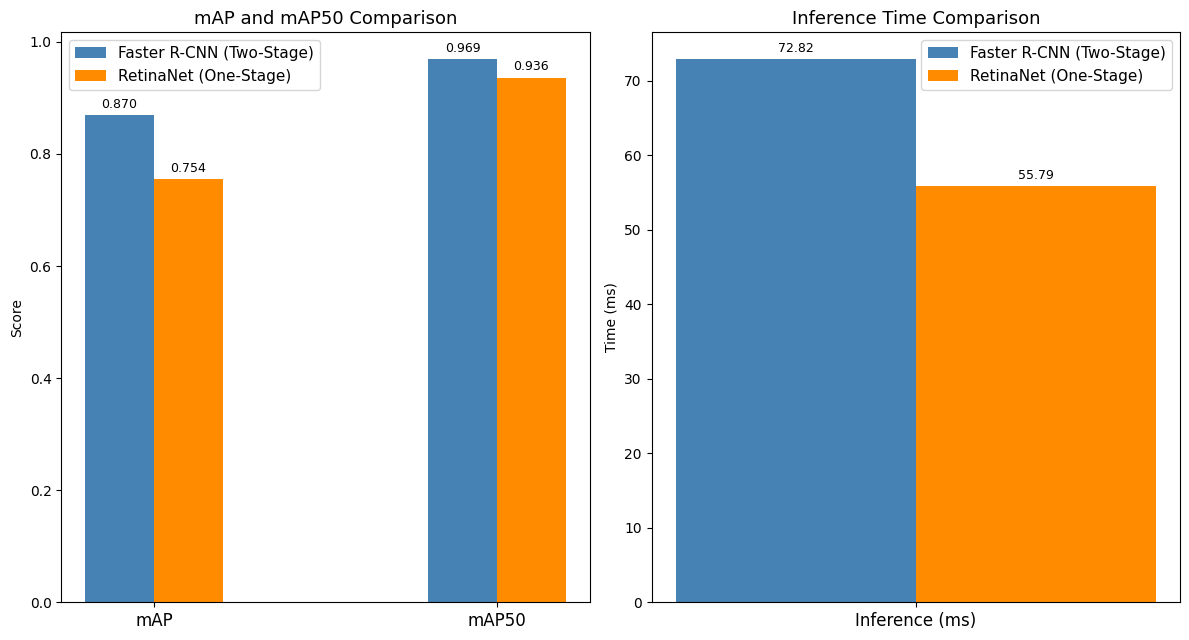

In [21]:
# Added bar chart to visually compare both models across all key metrics

# Data for plotting
metrics_labels = ['mAP', 'mAP50']
inference_label = ['Inference (ms)']

frcnn_metrics_vals = [frcnn_map, frcnn_map50]
retina_metrics_vals = [retina_map, retina_map50]

frcnn_inference_val = [frcnn_speed]
retina_inference_val = [retina_speed]

x_metrics = np.arange(len(metrics_labels))
x_inference = np.arange(len(inference_label))

width = 0.2  # Width for bars

fig, axes = plt.subplots(1, 2, figsize=(12, 6.5))

# First sub-plot
ax1 = axes[0]
bars_a1 = ax1.bar(x_metrics - width/2, frcnn_metrics_vals, width, label='Faster R-CNN (Two-Stage)', color='steelblue')
bars_b1 = ax1.bar(x_metrics + width/2, retina_metrics_vals, width, label='RetinaNet (One-Stage)', color='darkorange')

# Annotate each bar with its value for the first subplot
for bar in bars_a1 + bars_b1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points',
                 ha='center', va='bottom', fontsize=9)

ax1.set_xticks(x_metrics)
ax1.set_xticklabels(metrics_labels, fontsize=12)
ax1.set_title('mAP and mAP50 Comparison', fontsize=13)
ax1.set_ylabel('Score')
ax1.legend(fontsize=11)

# Second sub-plot
ax2 = axes[1]
bars_a2 = ax2.bar(x_inference - width/2, frcnn_inference_val, width, label='Faster R-CNN (Two-Stage)', color='steelblue')
bars_b2 = ax2.bar(x_inference + width/2, retina_inference_val, width, label='RetinaNet (One-Stage)', color='darkorange')

# Annotate each bar with its value for the second subplot
for bar in bars_a2 + bars_b2:
    height = bar.get_height()
    ax2.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points',
                 ha='center', va='bottom', fontsize=9)

ax2.set_xticks(x_inference)
ax2.set_xticklabels(inference_label, fontsize=12)
ax2.set_title('Inference Time Comparison', fontsize=13)
ax2.set_ylabel('Time (ms)')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

# Visualize the results of two methods for couple of images from test set

In [24]:
def calculate_iou(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def count_correct_detections(gt_boxes, pred_boxes, pred_scores, iou_threshold=0.5, score_threshold=0.5):
    correct_detections = 0
    if len(gt_boxes) == 0 or len(pred_boxes) == 0:
        return 0

    # Filter predicted boxes by score threshold
    filtered_pred_boxes = pred_boxes[pred_scores > score_threshold]
    filtered_pred_scores = pred_scores[pred_scores > score_threshold]

    if len(filtered_pred_boxes) == 0:
        return 0

    # Keep track of used predicted boxes
    used_pred_indices = [False] * len(filtered_pred_boxes)

    for gt_box in gt_boxes:
        best_iou = 0
        best_pred_idx = -1

        for i, pred_box in enumerate(filtered_pred_boxes):
            if used_pred_indices[i]:
                continue

            iou = calculate_iou(gt_box.cpu().numpy(), pred_box.cpu().numpy())

            if iou > best_iou:
                best_iou = iou
                best_pred_idx = i

        if best_iou >= iou_threshold:
            correct_detections += 1
            if best_pred_idx != -1:
                used_pred_indices[best_pred_idx] = True

    return correct_detections

def visualize_comparison(model_a, model_b, dataset, device, num_images=2, iou_threshold=0.5, score_threshold=0.5):
    model_a.eval()
    model_b.eval()

    fig, axes = plt.subplots(num_images, 3, figsize=(20, 6 * num_images))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)

    gt_title = "Ground Truth"

    with torch.no_grad():
        for i in range(num_images):
            # Get a random image from the test set
            image, target = dataset[i]
            img_tensor = image.to(device).unsqueeze(0)

            # Get predictions
            out_a = model_a(img_tensor)[0]
            out_b = model_b(img_tensor)[0]

            # Filter predictions by score threshold
            filtered_indices_a = out_a['scores'] > score_threshold
            filtered_boxes_a = out_a['boxes'][filtered_indices_a]
            filtered_scores_a = out_a['scores'][filtered_indices_a]

            filtered_indices_b = out_b['scores'] > score_threshold
            filtered_boxes_b = out_b['boxes'][filtered_indices_b]
            filtered_scores_b = out_b['scores'][filtered_indices_b]

            total_gt = len(target['boxes'])

            # Calculate correct detections
            correct_a = count_correct_detections(target['boxes'], out_a['boxes'], out_a['scores'], iou_threshold, score_threshold)
            correct_b = count_correct_detections(target['boxes'], out_b['boxes'], out_b['scores'], iou_threshold, score_threshold)

            titles = [
                gt_title,
                f"Faster R-CNN (Two-Stage) | Correct: {correct_a}/{total_gt})",
                f"RetinaNet (One-Stage) | Correct: {correct_b}/{total_gt})"
            ]

            # Convert image for plotting (C, H, W) -> (H, W, C)
            plot_img = image.permute(1, 2, 0).cpu().numpy()

            # Data for the three columns
            # For predicted results, we include scores to display them
            results = [
                (target['boxes'], None), # Ground Truth has no scores to display
                (filtered_boxes_a, filtered_scores_a),
                (filtered_boxes_b, filtered_scores_b)
            ]

            for col in range(3):
                ax = axes[i, col] if num_images > 1 else axes[col]
                ax.imshow(plot_img)
                ax.set_title(titles[col], fontsize=14)

                boxes, scores = results[col]

                for box_idx, box in enumerate(boxes):
                    xmin, ymin, xmax, ymax = box.cpu().numpy()
                    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                             linewidth=2, edgecolor='red' if col==0 else 'lime',
                                             facecolor='none')
                    ax.add_patch(rect)

                    if scores is not None: # Display score for predicted boxes
                        score = scores[box_idx].item()
                        ax.text(xmin, ymin - 10, f'{score:.2f}', color='blue', fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
                ax.axis('off')

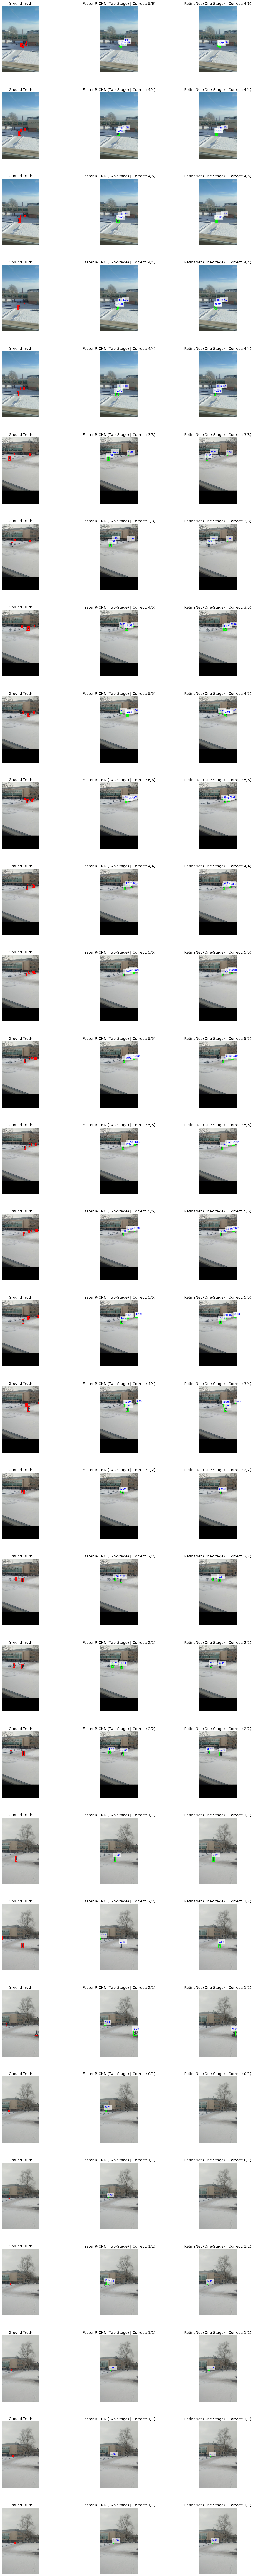

In [25]:
# Visualize predictions
visualize_comparison(model_frcnn, model_retina, test_dataset, device, num_images=30)
plt.show()

# <font color="darkblue"> Results and Conclusion:

In this assignment, I fine-tuned two pretrained object detection models - **Faster R-CNN** (two-stage) and **RetinaNet** (one-stage) - both using a `ResNet50` FPN backbone, on a custom RGB pedestrian dataset recorded at the *`University of Turku`* campus.

<font color="steelblue">**1. Dataset:**</font>

The dataset consists of 292 training images and 73 test images extracted from personal videos recorded from a window overlooking the UTU campus in winter conditions. Bounding box annotations around pedestrians were generated using a pretrained COCO model and manually reviewed in labelme.

<font color="steelblue">**2. Key Implementation Decisions:**</font>

- **Faster R-CNN**: `num_classes=2` (person + background as explicit class, softmax head). Trained with `lr=0.005`.
- **RetinaNet**: `num_classes=2` (person + background). Trained with `lr=0.0005` and gradient clipping (`max_norm=1.0`) to prevent NaN loss. `score_thresh=0.3` during training, lowered to `0.05` during evaluation.
- Both models used `trainable_backbone_layers=3` for domain adaptation while preserving COCO pretrained weights.

<font color="steelblue">**3. Results:** </font>

| Metric | Faster R-CNN | RetinaNet |
|--------|-------------|----------|
| mAP | 0.8697 | 0.7544 |
| mAP50 | 0.9685 | 0.9363 |
| mean inference (ms) | 72.82 | 55.79 |


<font color="steelblue">**4. Observations:**</font>

- **Faster R-CNN** achieved excellent results (mAP=0.87, mAP50=0.97), demonstrating the power of its two-stage design, the RPN isolates pedestrian candidates before classification, which works well for small, spread-out pedestrians.
- **RetinaNet** as a one-stage detector is faster at inference (~56ms vs ~73ms per image). Its focal loss effectively handles the class imbalance between background and foreground anchors.
- Both models benefited significantly from COCO pretraining - high mAP was achievable with only ~300 images, demonstrating the effectiveness of transfer learning.
- The winter outdoor scene (snow, natural lighting, small distant pedestrians) presented a domain shift from typical COCO training data, yet both models adapted well.

<font color="steelblue">**5. Summary:**</font>

For applications where **accuracy is critical** (surveillance, safety systems), Faster R-CNN is the preferred choice. For **real-time applications** where speed matters, RetinaNet offers a better trade-off. The best model depends on deployment constraints.